# Calibration of the  spectra of CTIO Data in November 2016
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : December 19th 2016

Compare simulation and fitted spectrum

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [10]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [11]:
inputdir="./spectrum_calibspec"
object_name='HD14943'

In [12]:
#outputdir="./spectrum_calibspec"

In [13]:
#ensure_dir(outputdir)

In [14]:
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10'

In [15]:
simspectrasummary='AllSimSpectra_'+object_name+'.fits'

In [16]:
simspectracalibresult='SpecCalibFitResults_'+object_name +'.fits'

## Load the Fits results for the calibration

In [17]:
hdu_list=fits.open(simspectracalibresult)
hdu_list.info()

Filename: SpecCalibFitResults_HD14943.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   ()              
1                ImageHDU         7   (2, 117)     float64   
2                ImageHDU         7   (2, 117)     float64   


In [18]:
print hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ANALYST = 'Sylvie Dagoret-Campagne'                                             OBJ-NAME= 'HD14943 '                                                            COMMENT Fits straight line on spectra                                           END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [19]:
fitparam_rightspectra=hdu_list[1].data
fitparam_leftspectra=hdu_list[2].data

## Location of calibrated spectra
----------------------------------

In [20]:
input_filelist=os.listdir(inputdir) 

In [21]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [22]:
print input_filelist[0:5]

['calibSpectra_HD14943_2016_11_23T01_45_51_1.fits'
 'calibSpectra_HD14943_2016_11_23T01_46_55_2.fits'
 'calibSpectra_HD14943_2016_11_23T01_47_58_3.fits'
 'calibSpectra_HD14943_2016_11_23T01_52_42_4.fits'
 'calibSpectra_HD14943_2016_11_23T01_54_05_5.fits']


In [23]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [24]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [25]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [26]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [27]:
print indexes_files

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116]


In [31]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [32]:
sorted_files[0:5]

array(['./spectrum_calibspec/calibSpectra_HD14943_2016_11_23T01_45_51_1.fits',
       './spectrum_calibspec/calibSpectra_HD14943_2016_11_23T01_46_55_2.fits',
       './spectrum_calibspec/calibSpectra_HD14943_2016_11_23T01_47_58_3.fits',
       './spectrum_calibspec/calibSpectra_HD14943_2016_11_23T01_52_42_4.fits',
       './spectrum_calibspec/calibSpectra_HD14943_2016_11_23T01_54_05_5.fits'], 
      dtype='|S70')

## Build full filename
----------------------------

In [33]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [34]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [35]:
print sorted_filenames.shape

(117,)


## Acces to spectrum data
----------------------------------

In [36]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [37]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_leftspectra_fitparam = []
    all_rightspectra_fitparam = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
        
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum=table_data.field('CalibLeftSpec')
        left_spectrum_fitparam=table_data.field('CalibLeftSpecFitParam')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum=table_data.field('CalibRightSpec')
        right_spectrum_fitparam=table_data.field('CalibRightSpecFitParam')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_fitparam.append(left_spectrum_fitparam)
        all_rightspectra_fitparam.append(right_spectrum_fitparam)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_leftspectra_wl, \
        all_rightspectra_wl

In [38]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [39]:
len(all_rightspectra)

117

In [40]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].set_xlim(0.,1000.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

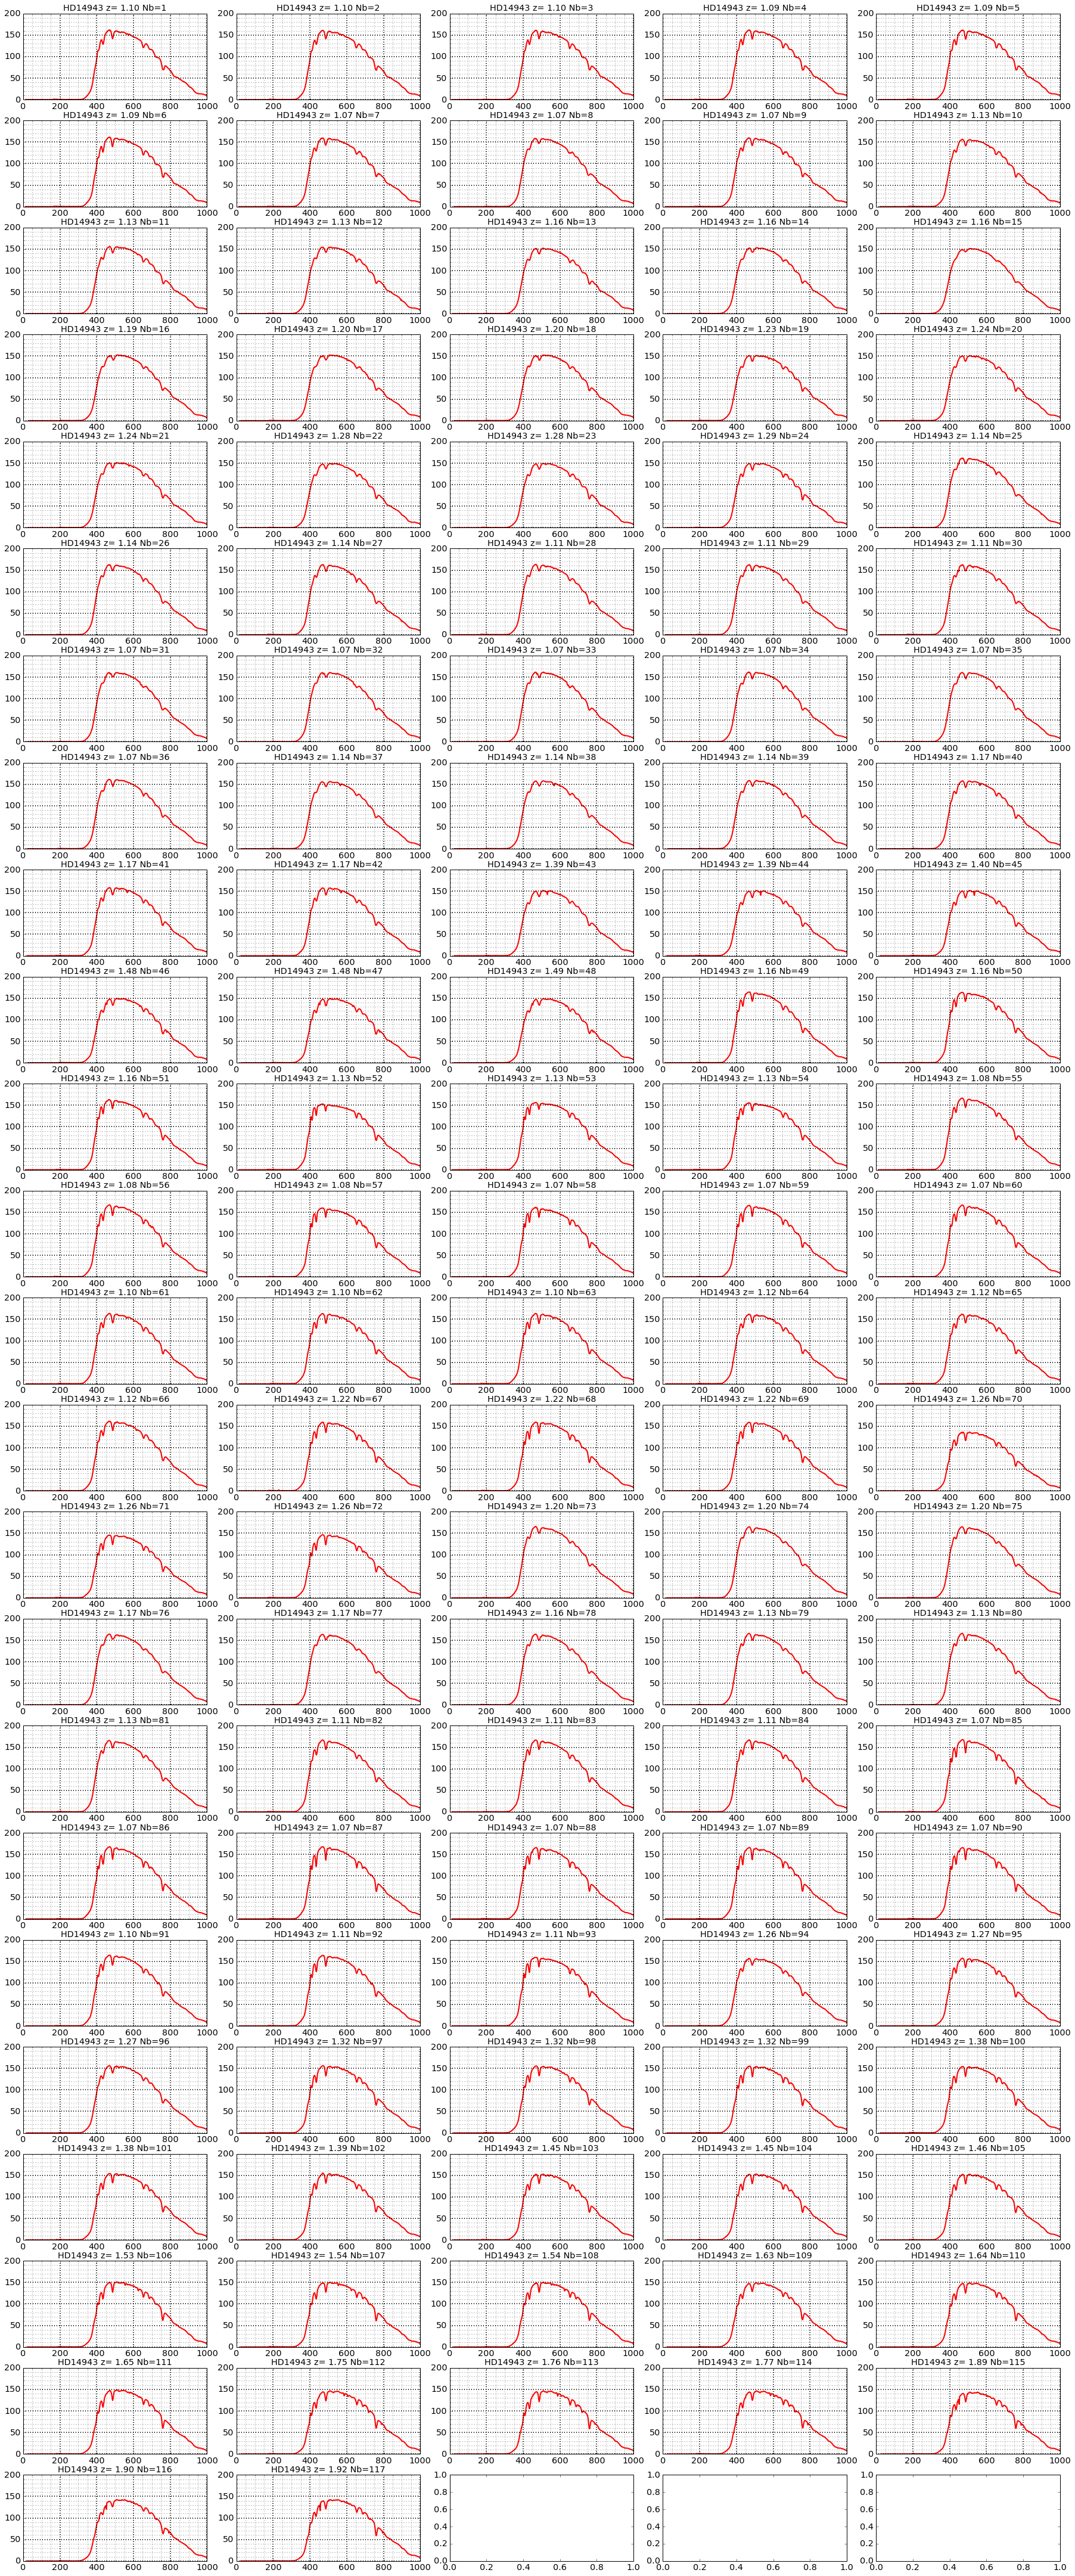

In [41]:
ShowSpectra(all_rightspectra,all_rightspectra_wl,all_titles,object_name)

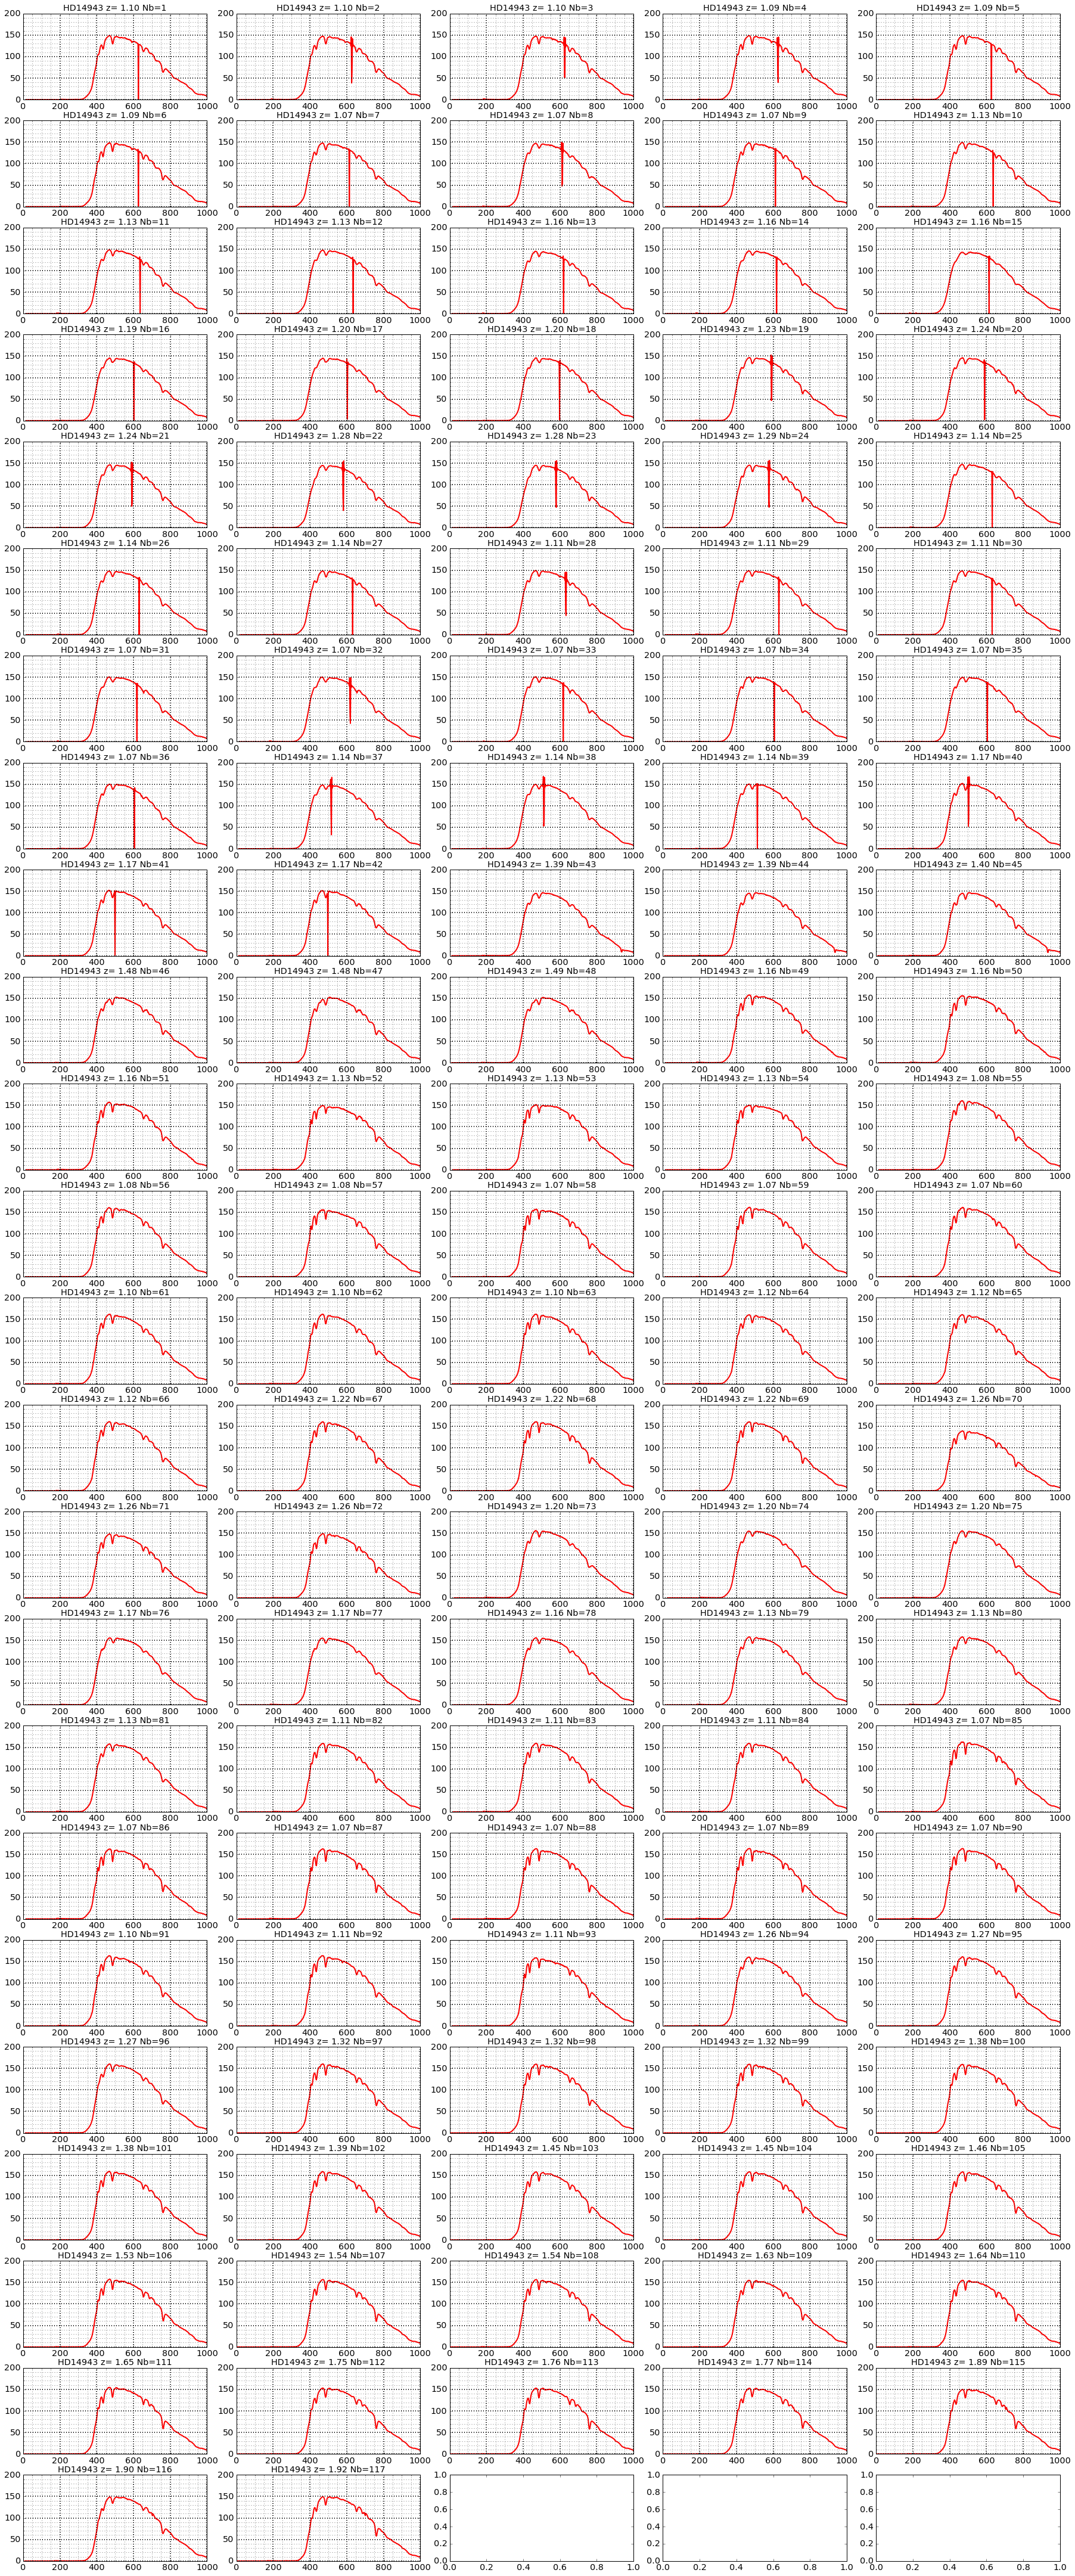

In [42]:
ShowSpectra(all_leftspectra,all_leftspectra_wl,all_titles,object_name)

## Read the simulated spectra

In [43]:
inputsim_filelist=os.listdir(simspecdir) 

In [44]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [45]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev100_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev101_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev102_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev103_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev104_y2016_m10_aver_spectra.fits']


In [46]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',inputsim_filelist[0])

['100']


In [47]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [48]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [49]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [50]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [51]:
print indexes_simfiles

[100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117  11  12  13  14  15  16  17  18  19   1  20  21  22  23  24  25  26
  27  28  29   2  30  31  32  33  34  35  36  37  38  39   3  40  41  42
  43  44  45  46  47  48  49   4  50  51  52  53  54  55  56  57  58  59
   5  60  61  62  63  64  65  66  67  68  69   6  70  71  72  73  74  75
  76  77  78  79   7  80  81  82  83  84  85  86  87  88  89   8  90  91
  92  93  94  95  96  97  98  99   9]


In [52]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [53]:
sorted_simindexes

array([ 28,  39,  50,  61,  72,  83,  94, 105, 116,  10,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  11,  12,  13,  14,  15,  16,  17,  18])

In [54]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [55]:
print sorted_simnumbers # check

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [56]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [57]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev1_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev2_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev3_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev4_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev5_y2016_m10_aver_spectra.fits']


In [58]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [59]:
# crash because it blows up fits IO capability : too many files open
#all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [60]:
# better open a singel file produced by view_SimSpectrum

hdu_list=fits.open(simspectrasummary)
header=hdu_list[0].header
print header
simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1888                                                  NAXIS2  =                  118                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

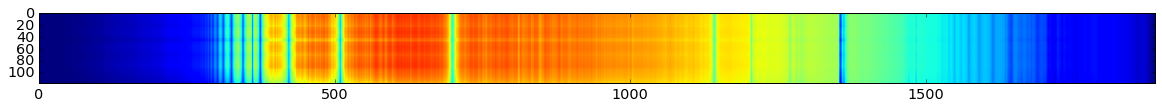

In [61]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=8e-9)

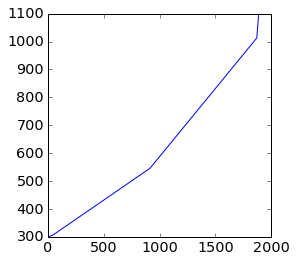

In [62]:
plt.plot(simspectra_data[0,:])
wl_simspectra=simspectra_data[0,:]

In [86]:
wl_O2Aline=759.37
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

wl_calib= np.array([wl_O2Aline, wl_Haline, wl_Hbline, wl_Hgline ])

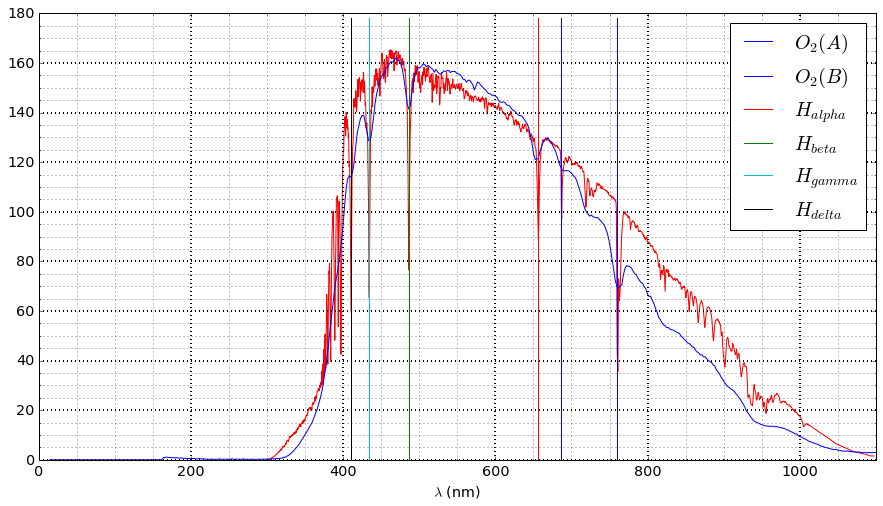

In [96]:
sel=0
thespectrum=all_rightspectra[sel]
thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(simspectra_data[0,:],simspectra_data[sel+1,:]*2.4e10,'r-')
ax.plot(thewl,thespectrum,'b-')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

In [115]:
print simspectra_data[0,:].shape
print simspectra_data[sel+1,:].shape

(1888,)
(1888,)


In [162]:
def smooth(x,window_len=11,window='hanning'):
    """
    smooth the data using a window with requested size.     
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
     (with the window size) in both ends so that transient parts are minimized
     in the begining and end part of the output signal.     
     input:
     x: the input signal 
     window_len: the dimension of the smoothing window; should be an odd integer
     window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman
     flat window will produce a moving average smoothing.

     output:
        the smoothed signal         
        example:
 
         t=linspace(-2,2,0.1)
         x=sin(t)+randn(len(t))*0.1
         y=smooth(x)
         
         see also: 
           
         numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
           scipy.signal.lfilter
    
           TODO: the window parameter could be the window itself if an array instead of a string
           NOTE: length(output) != length(input), 
           to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
       """ 
      
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
 
    if window_len<3:
        return x
   
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
       
  
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
     
    y=np.convolve(w/w.sum(),s,mode='valid')
    #return y[(window_len/2-1):-(window_len/2+1)]
    return y[(window_len/2):-(window_len/2)] 
    #return y[(window_len/2+1):-(window_len/2-1)] 

In [163]:
window_len=61 # odd
smoothed_spectrum=smooth(simspectra_data[sel+1,:],window_len=window_len)

In [164]:
print (simspectra_data[0,:]).shape
print smoothed_spectrum.shape

(1888,)
(1888,)


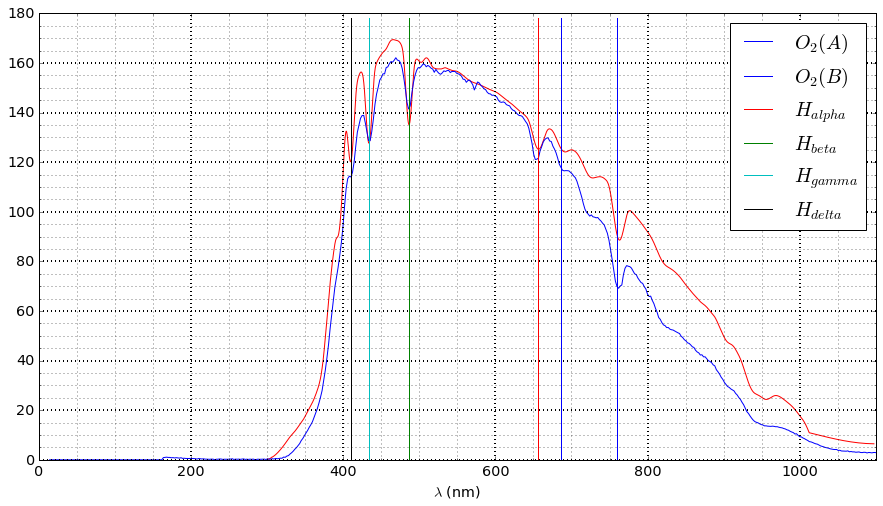

In [165]:
sel=0
thespectrum=all_rightspectra[sel]
thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(simspectra_data[0,:],smoothed_spectrum*2.5e10,'r-')
ax.plot(thewl,thespectrum,'b-')
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## Comparison of spectra

### Save outputfilename
Results of the fits for right and left spectra are saved as images